In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

ModuleNotFoundError: No module named 'datenspende'

In [154]:
lc_u = np.load('uid_per_shb_fatigue(1).npy')

In [155]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

uid = []
sex = []
age = []
df_lcu = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                 
            df_lcu.append(df)
            demo_info = f.split("/")[-1].split('.')[0]
            sex.append(re.split('(\d+)',demo_info)[0])
            age.append(int(re.split('(\d+)',demo_info)[1]))
            uid.append(int(f.split("/")[-1].split('.')[1][1:])) 

In [156]:
perss_user = pd.DataFrame(data =  np.array([uid, sex, age]).T,columns = ['uid', 'sex', 'age'])

## criteria
- heart rate: mean rhr day decreased by more than 2 bpm after test, mean rhr night increased by more than 2bpm after test
- high activty: mean times of ha per week more than 2 times lower/higher (wo seasonality)
- number of fatigue & shortness of breath > 10

### heart rate

In [158]:
seas = pd.read_csv('mean_rhr_pdps.csv',index_col=0)

In [159]:
nightbt = []
nightat = []

rhrbt = []
rhrat = []

daybt = []
dayat = []

dayrbt = []
dayrat = []
for d in range(len(df_lcu)):
    df = df_lcu[d].copy()
    df = df[(pd.to_timedelta(df.day_totest).dt.days >= -62) &(pd.to_timedelta(df.day_totest).dt.days <= 180)]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    sc = df.source.unique()[0]
    seas_sc = seas[seas.source == sc].copy()
    seas_sc['date'] = pd.to_datetime(seas_sc['date'])
    df = df[['start','rhr','hr','steps','date','day_of_week', 'dt','day_totest', 'week_totest','phase']]
    df_seas = pd.merge(df,seas_sc, how = 'outer', on ='date')
    #df_seas = df_seas.dropna()
    df_seas['rhr_cl'] = df_seas['rhr'] - df_seas['mean']
    df_seas['hr_cl'] = df_seas['hr'] - df_seas['mean']
    
    df_seas['start'] = pd.to_datetime(df_seas['start'])
    
    subd = df_seas[df_seas.day_totest.dt.days < - 7]
    nightbt.append(subd[(pd.to_datetime(subd['start']).dt.time < pd.to_datetime('07:00:00').time())]['hr_cl'].dropna().min())
    rhrbt.append(subd['rhr_cl'].dropna().mean())
    daybt.append(subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time()) ]['rhr_cl'].dropna().mean())
    dayrbt.append(subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time()) ]['rhr_cl'].dropna().mean())
    
    subd = df_seas[df_seas.day_totest.dt.days >= - 7]
    nightat.append(subd[(pd.to_datetime(subd['start']).dt.time < pd.to_datetime('07:00:00').time())]['hr_cl'].dropna().min())
    rhrat.append(subd['rhr_cl'].dropna().mean())
    dayat.append(subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time()) ]['rhr_cl'].dropna().mean())
    dayrat.append(subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time()) ]['rhr_cl'].dropna().mean())
    

In [228]:
perss_user['RHR Night increase by 2 bpm or more'] = np.array(nightat)  >= 2+np.array(nightbt)
perss_user['RHR Day decrease by 2 bpm or more '] = np.array(dayrat)  <= np.array(dayrbt) - 2
perss_user['RHR Night decrease by 2 bpm or more'] = np.array(nightat)  <= np.array(nightbt) -2
perss_user['RHR Day increase by 2 bpm or more '] = np.array(dayrat)  >= 2+np.array(dayrbt)



### high activity

In [161]:
dfagg = []
for df in df_lcu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
 
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    d_agg = d_agg[(pd.to_timedelta(d_agg.day_totest).dt.days <= 180) & (pd.to_timedelta(d_agg.day_totest).dt.days >= -62)]
    d_agg['steps'] = d_agg['steps'] - 4
    dfagg.append(d_agg)

In [162]:
seas = pd.read_csv('mean_steps_pdps.csv',index_col=0)

In [163]:
seas['date'] = pd.to_datetime(seas['date'] )

In [164]:
n_sps = []
un_week = []
bef = []
aft = []
for i in range(len(df_lcu)):
    d = dfagg[i]
    sc = d.source[d.source.notna()].iloc[0]
    seas_sc = seas[seas.source == sc].copy()
    d = pd.merge(dfagg[i].groupby(['week_totest','date']).sum().reset_index(), seas_sc, how='inner',on='date')
    n_sp = []
    for w in d['week_totest'].unique():
        #dpw = d[d['week_totest'] == w].groupby('date').sum()
        dpw = d[d['week_totest'] == w]
        #n_sp.append(len(dpw[dpw['steps'] > 10000]))
        n_sp.append(np.count_nonzero(dpw['steps'] > dpw['mean'] + dpw['std']))
    un_week.append(d['week_totest'].unique())
    n_sps.append(n_sp)
    
    d['ha'] = d['steps'] > d['mean'] + d['std']
    bef.append(d[d['week_totest'] < 0]['ha'].sum()/len(d[d['week_totest'] < 0]['week_totest'].unique()))
    aft.append(d[d['week_totest'] >= 0]['ha'].sum()/len(d[d['week_totest'] >= 0]['week_totest'].unique()))

In [165]:
perss_user['high act reduction'] = np.array(aft)/bef <= 0.5

/tmp/ipykernel_110820/3984030005.py:1: RuntimeWarning: divide by zero encountered in divide
  perss_user['high act reduction'] = np.array(aft)/bef <= 0.5
/tmp/ipykernel_110820/3984030005.py:1: RuntimeWarning: invalid value encountered in divide
  perss_user['high act reduction'] = np.array(aft)/bef <= 0.5


In [168]:
perss_user.mean()

uid                                              inf
age                                    7.808664e+101
RHR Night increase by 2 bpm or more     3.846154e-02
RHR Day decrease by 2 bpm or more       9.615385e-02
high act reduction                      1.923077e-01
dtype: float64

In [170]:
# get age
def get_symptoms(user_ids):
    
    if isinstance(user_ids, int) or isinstance(user_ids, np.int64):
        formatter = f'({user_ids})'
    elif len(user_ids) == 1:
        formatter = f'({user_ids[0]})'
    else:
        formatter = tuple(user_ids) 
    
    query = f"""
    select
        a.id,
        a.user_id, 
        a.element,
        a.created_at
    from 
        rocs.datenspende.answers a
    where 
        a.user_id IN {formatter}  and (a.question = 137 or a.question = 8 )

    """

    df_all = query_pg_df(query)
    df_all['dt'] = pd.to_datetime(df_all['created_at'],unit='ms')
    df_all['dt'] = df_all['dt'].dt.date
    df_all = df_all[df_all['dt'] >= pd.to_datetime('2021-10-25')]
    df_all = df_all[['user_id', 'element', 'dt']]
     
    df_868 = df_all[(df_all.element == 868)|(df_all.element == 49)].copy()
    df_868.loc[:,'element'] = [True] * len(df_868)
    df_868 = df_868.rename({'element':868}, axis=1)
    df_867 = df_all[df_all.element == 867].copy()
    df_867.loc[:,'element'] = True
    df_867 = df_867.rename({'element':867}, axis=1)
    df_866 = df_all[df_all.element == 866].copy()
    df_866.loc[:,'element'] = True
    df_866 = df_866.rename({'element':866}, axis=1)
    df_865 = df_all[(df_all.element == 865)|(df_all.element == 48)].copy()
    df_865.loc[:,'element'] = True
    df_865 = df_865.rename({'element':865}, axis=1)
    df_864 = df_all[(df_all.element == 864)|(df_all.element == 47)].copy()
    df_864.loc[:,'element'] = True
    df_864 = df_864.rename({'element':864}, axis=1)
    df_863 = df_all[(df_all.element == 863)|(df_all.element == 46)].copy()
    df_863.loc[:,'element'] = True
    df_863 = df_863.rename({'element':863}, axis=1)
    df_862 = df_all[(df_all.element == 862)|(df_all.element == 45)].copy()
    df_862.loc[:,'element'] = True
    df_862 = df_862.rename({'element':862}, axis=1)
    df_861 = df_all[(df_all.element == 861)|(df_all.element == 44)].copy()
    df_861.loc[:,'element'] = True
    df_861 = df_861.rename({'element':861}, axis=1)
    df_860 = df_all[(df_all.element == 860)|(df_all.element == 43)].copy()
    df_860.loc[:,'element'] = True
    df_860 = df_860.rename({'element':860}, axis=1)
    df_859 = df_all[(df_all.element == 859)|(df_all.element == 42)].copy()
    df_859.loc[:,'element'] = True
    df_859 = df_859.rename({'element':859}, axis=1)
    df_858 = df_all[(df_all.element == 858)|(df_all.element == 41)].copy()
    df_858.loc[:,'element'] = True
    df_858 = df_858.rename({'element':858}, axis=1)
    df_857 = df_all[(df_all.element == 857)|(df_all.element == 40)].copy()
    df_857.loc[:,'element'] = True
    df_857 = df_857.rename({'element':857}, axis=1)
    
    dfs = [df_868, df_867, df_866, df_865, df_864, df_863, df_862, df_861, df_860, df_859, df_858, df_857]
    
    
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','dt'],
                                            how='outer'), dfs).fillna(False)
    df_merged['upd'] = 1
    
    
    return df_merged

In [ ]:
pos_test = pd.read_csv('pos_testdate.csv',index_col=0)

In [202]:
n_symp = []
for userid in perss_user['uid']:
    dfm = get_symptoms(int(userid))
    sympat = dfm[dfm['dt'] > pd.to_datetime(pos_test[pos_test['user_id'] == int(userid)].dt.values)[0]]
    n_symp.append(np.count_nonzero(sympat[867] & sympat[860]) > 10 )

/home/jovyan/datenspende-science/datenspende/utils/load_from_postgres.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/home/jovyan/datenspende-science/datenspende/utils/load_from_postgres.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/home/jovyan/datenspende-science/datenspende/utils/load_from_postgres.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/home/jovyan/datenspende-science/datenspende/utils/load_from_pos

In [203]:
perss_user['Shortness of Breath & Fatigue > 10'] = n_symp

In [207]:
perss_user.iloc[:,3:].columns

Index(['RHR Night increase by 2 bpm or more',
       'RHR Day decrease by 2 bpm or more ', 'high act reduction',
       'Shortness of Breath & Fatigue > 10'],
      dtype='object')

In [214]:
x[:-1]+0.5

array([0.5, 1.5, 2.5, 3.5])

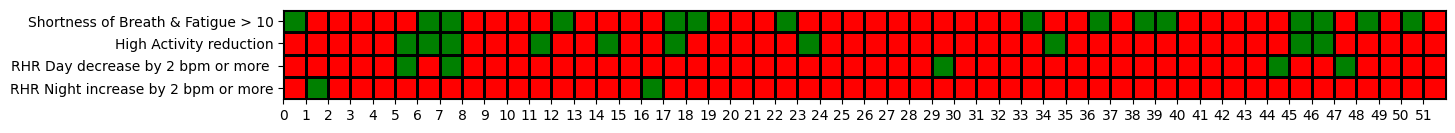

In [225]:
from matplotlib import colors

data = perss_user.iloc[:,3:].values

# create discrete colormap
cmap = colors.ListedColormap(['red', 'green'])


fig, ax = plt.subplots(figsize=(15,10))
ax.pcolormesh(data.T, cmap=cmap,edgecolor='k')

# draw gridlines
ax.set_xticks(np.arange(0, len(perss_user), 1));
x = np.arange(0, 5, 1)
ax.set_yticks(x[:-1]+0.5)
#ax.set_xticks(np.arange(0, 5, 1));
#ax.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_yticklabels(['RHR Night increase by 2 bpm or more','RHR Day decrease by 2 bpm or more ', 'High Activity reduction','Shortness of Breath & Fatigue > 10'],rotation=0)
ax.set_aspect('equal')
plt.show()



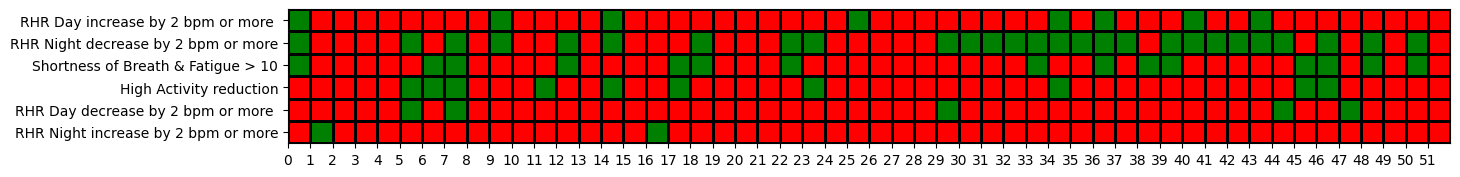

In [230]:
from matplotlib import colors

data = perss_user.iloc[:,3:].values

# create discrete colormap
cmap = colors.ListedColormap(['red', 'green'])


fig, ax = plt.subplots(figsize=(15,10))
ax.pcolormesh(data.T, cmap=cmap,edgecolor='k')

# draw gridlines
ax.set_xticks(np.arange(0, len(perss_user), 1));
x = np.arange(0, 7, 1)
ax.set_yticks(x[:-1]+0.5)
#ax.set_xticks(np.arange(0, 5, 1));
#ax.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_yticklabels(['RHR Night increase by 2 bpm or more','RHR Day decrease by 2 bpm or more ', 'High Activity reduction','Shortness of Breath & Fatigue > 10','RHR Night decrease by 2 bpm or more','RHR Day increase by 2 bpm or more '],rotation=0)
ax.set_aspect('equal')
plt.show()

In [229]:
perss_user


,uid,sex,age,RHR Night increase by 2 bpm or more,RHR Day decrease by 2 bpm or more,high act reduction,Shortness of Breath & Fatigue > 10,RHR Night decrease by 2 bpm or more,RHR Day increase by 2 bpm or more
0,1076206,male,40,False,False,False,True,True,True
1,1239657,male,60,True,False,False,False,False,False
2,601007,male,50,False,False,False,False,False,False
3,1217724,female,50,False,False,False,False,False,False
4,1225571,male,55,False,False,False,False,False,False
5,468824,nd,75,False,True,True,False,True,False
6,1232956,male,45,False,False,True,True,False,False
7,146789,female,45,False,True,True,True,True,False
8,1229017,female,40,False,False,False,False,False,False
9,198054,male,50,False,False,False,False,True,True
